In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ETL

In [2]:
df = pl.read_ods('../projecoes_2024_tab1_idade_simples.ods')

In [3]:
df.head()

IDADE,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,…,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
i64,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,"""Ambos""",0,"""BR""","""Brasil""",3423475,3347313,3274356,3212295,3163041,3123546,3095244,3013232,2984981,2968870,2918162,2922648,2935674,2922850,2952907,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799,2527241,2484344,2431971,2386874,2346516,2310023,2277579,2248982,2222783,…,2154526,2135115,2116131,2096926,2078343,2060737,2043253,2025224,2006805,1988681,1970850,1952779,1934024,1914865,1895555,1875672,1855064,1833975,1812765,1791035,1768271,1744864,1721915,1700174,1678628,1656669,1635347,1615589,1597609,1580751,1564427,1549026,1534801,1521584,1509151,1497237,1485716
1,"""Ambos""",0,"""BR""","""Brasil""",3450022,3406966,3332612,3261091,3200484,3152623,3114345,3087163,3005979,2978318,2958122,2902678,2910301,2925710,2913563,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031,2587620,2519770,2477769,2426282,2382021,2342453,2306725,2275013,2246849,…,2173391,2152558,2133170,2114220,2095037,2076482,2058897,2041452,2023485,2005112,1987041,1969262,1951239,1932531,1913420,1894153,1874314,1853749,1832699,1811533,1789840,1767114,1743744,1720831,1699126,1677614,1655686,1634395,1614666,1596716,1579885,1563579,1548205,1534002,1520805,1508394,1496496
2,"""Ambos""",0,"""BR""","""Brasil""",3461038,3444450,3401900,3327924,3256791,3196543,3149015,3111038,3084081,3003124,2972125,2948274,2895233,2904628,2920488,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175,2673622,2583366,2516128,2474683,2423745,2380000,2340927,2305679,2274237,…,2195411,2172594,2151751,2132355,2113393,2094206,2075638,2058060,2040638,2022691,2004339,1986288,1968526,1950525,1931835,1912741,1893493,1873673,1853126,1832096,1810943,1789265,1766560,1743207,1720312,1698618,1677119,1655206,1633932,1614217,1596273,1579457,1563166,1547800,1533609,1520415,1508015
3,"""Ambos""",0,"""BR""","""Brasil""",3469109,3458052,3441638,3399284,3325501,3254582,3194489,3147097,3109229,3082358,2998921,2965164,2943133,2891454,2901225,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055,2762809,2670309,2580521,2513700,2472629,2422059,2378663,2339922,2304869,…,2219102,2194592,2171767,2150923,2131520,2112549,2093350,2074792,2057237,2039837,2021912,2003581,1985549,1967809,1949823,1931153,1912076,1892846,1873045,1852515,1831500,1810359,1788702,1766017,1742677,1719797,1698118,1676639,1654738,1633474,1613776,1595841,1579039,1562761,1547399,1533216,1520035
4,"""Ambos""",0,"""BR""","""Brasil""",3477903,3466901,3455987,3439662,3397467,3323811,3253080,3193054,3145729,3107906,3079235,2993806,2961429,2940420,2889030,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777,2869950,2760203,2668025,2578548,2512000,2471172,2420847,2377678,2339077,…,2244420,2218258,2193747,2170921,2150073,2130661,2111688,2092497,2073963,2056429,2039050,2021146,2002834,1984824,1967099,1949133,1930480,1911423,1892208,1872427,1851909,1830912,1809791,1788148,1765483,1742156,1719290,1697627,1676166,1654275,1633030,1613338,1595416,1578625,1562356,1547006,1532831


In [4]:
df = df.filter(
    pl.col('LOCAL') == 'Brasil'
).drop([
    'CÓD.', 'SIGLA', 'LOCAL'
]).rename({
    'IDADE': 'idade',
    'SEXO':  'sexo'
}).unpivot(
    index=['idade', 'sexo'],
    on=[str(x) for x in range(2000, 2071)],
    variable_name='ano',
    value_name='populacao_projetada'
).with_columns(
    pl.col('idade').cast(pl.Int8),
    pl.col('sexo').cast(pl.Categorical),
    pl.col('ano').cast(pl.Int16),
    pl.col('populacao_projetada').cast(pl.Float32)
)

In [5]:
df.head()

idade,sexo,ano,populacao_projetada
i8,cat,i16,f32
0,"""Ambos""",2000,3.423475e6
1,"""Ambos""",2000,3.450022e6
2,"""Ambos""",2000,3.461038e6
3,"""Ambos""",2000,3.469109e6
4,"""Ambos""",2000,3.477903e6


# ANÁLISE POR SEXO E ANO

In [6]:
df_sexo_ano = df.group_by(['sexo', 'ano']).agg(
    pl.col('populacao_projetada').sum()
).sort('ano', descending=False)

In [7]:
df_sexo_ano.head()

sexo,ano,populacao_projetada
cat,i16,f32
"""Ambos""",2000,1.74695872e8
"""Homens""",2000,8.5720712e7
"""Mulheres""",2000,8.897524e7
"""Mulheres""",2001,9.0182312e7
"""Ambos""",2001,1.77003712e8


In [8]:
anos = sorted(df.select('ano').unique().to_series().to_list())

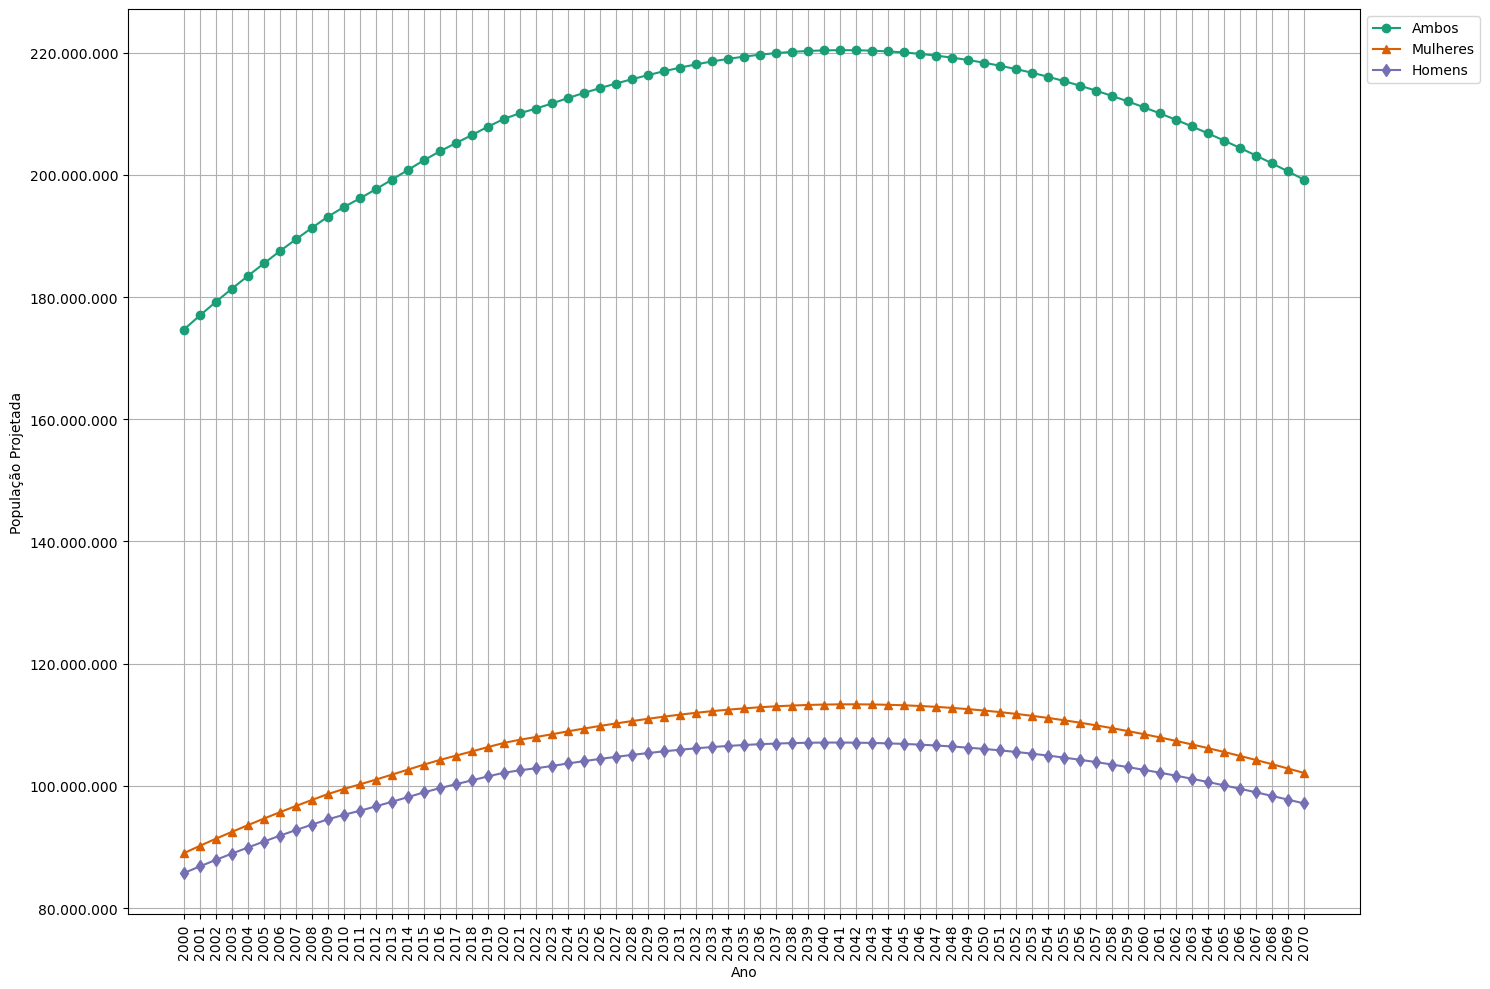

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))

cores = plt.get_cmap('Dark2').colors
marcadores = ['o', '^', 'd']

for (sexo, grupo), cor, marcador in zip(df_sexo_ano.group_by('sexo'), cores, marcadores):
    ax.plot(
        grupo.select('ano'),
        grupo.select('populacao_projetada'),
        color=cor,
        marker=marcador,
        label=sexo
    )

ax.set_ylabel('População Projetada')
ax.set_xlabel('Ano')
ax.grid()
ax.tick_params('x', rotation=90)
ax.set_xticks(anos)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
)

plt.tight_layout()
plt.show()

# ANÁLISE POR GRUPO ETÁRIO E ANO

In [10]:
df.head()

idade,sexo,ano,populacao_projetada
i8,cat,i16,f32
0,"""Ambos""",2000,3.423475e6
1,"""Ambos""",2000,3.450022e6
2,"""Ambos""",2000,3.461038e6
3,"""Ambos""",2000,3.469109e6
4,"""Ambos""",2000,3.477903e6


In [11]:
df_grupoetario_ano = df.with_columns(
    grupo_etario = pl.col('idade').cut(
        breaks=[18, 30, 60],
        labels=['Menor', 'Jovem Adulto', 'Adulto', 'Idoso'],
        left_closed=True
)).group_by(['ano', 'grupo_etario']).agg(
    pl.col('populacao_projetada').sum()
).sort('ano', descending=False)

In [12]:
df_grupoetario_ano.head()

ano,grupo_etario,populacao_projetada
i16,cat,f32
2000,"""Idoso""",3.045984e7
2000,"""Menor""",1.26031888e8
2000,"""Jovem Adulto""",7.5658824e7
2000,"""Adulto""",1.1724136e8
2001,"""Idoso""",3.129652e7


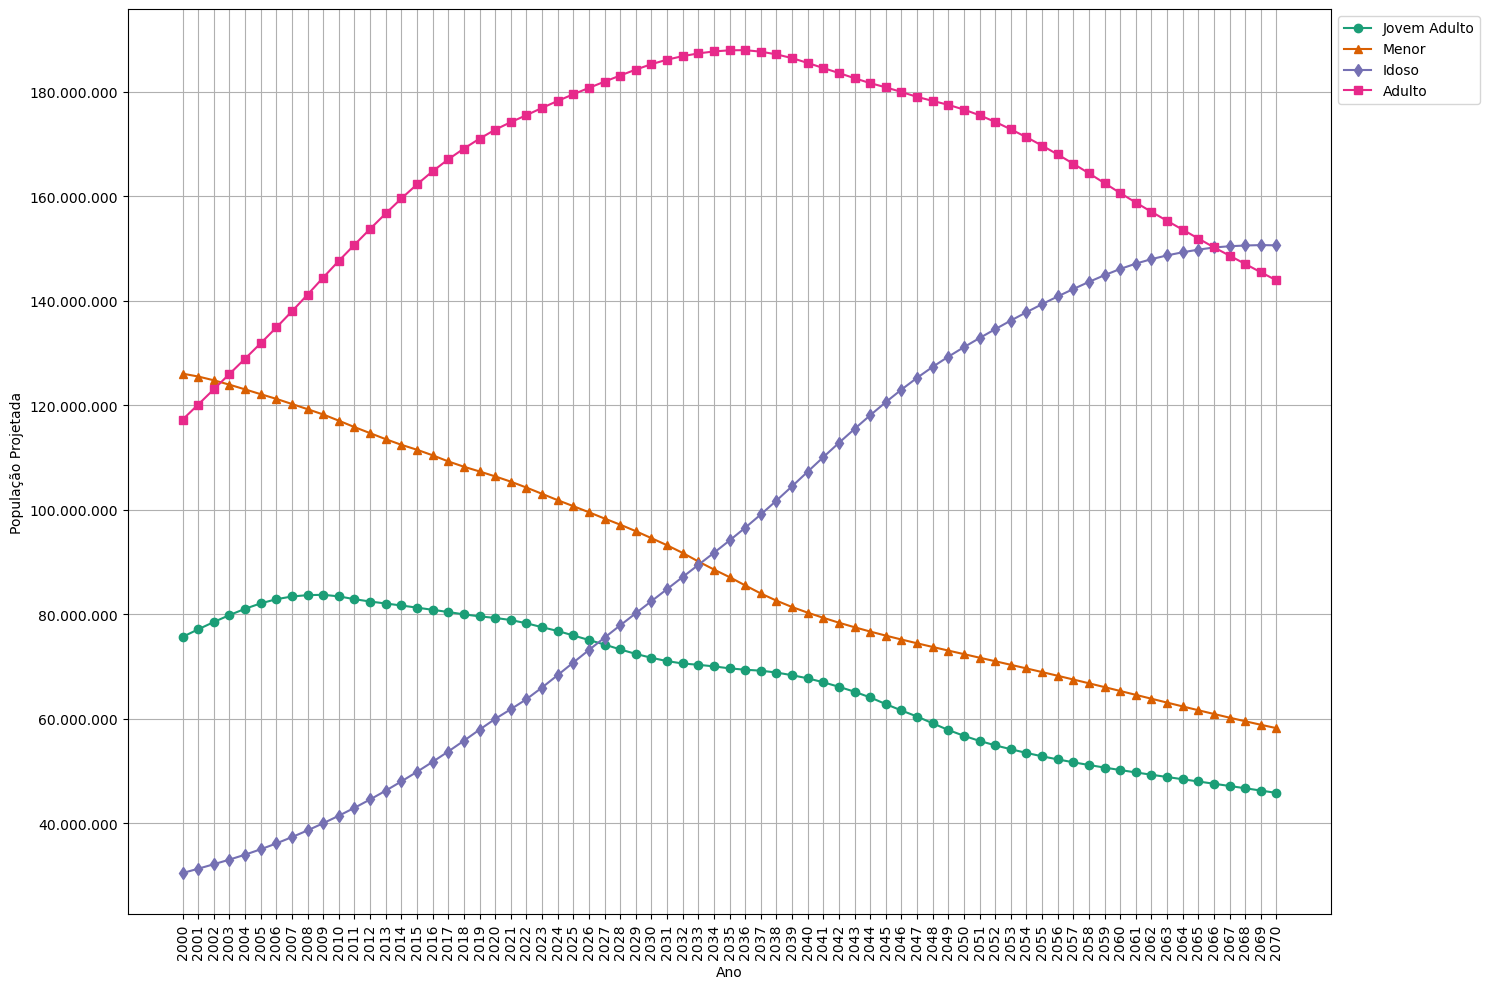

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

cores = plt.get_cmap('Dark2').colors
marcadores = ['o', '^', 'd', 's']

for (grupo_etario, grupo), cor, marcador in zip(df_grupoetario_ano.group_by('grupo_etario'), cores, marcadores):
    ax.plot(
        grupo.select('ano'),
        grupo.select('populacao_projetada'),
        color=cor,
        marker=marcador,
        label=grupo_etario
    )

ax.set_ylabel('População Projetada')
ax.set_xlabel('Ano')
ax.grid()
ax.tick_params('x', rotation=90)
ax.set_xticks(anos)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
)

plt.tight_layout()
plt.show()

# ANÁLISE POR SEXO, GRUPO ETÁRIO E ANO

In [14]:
df.head()

idade,sexo,ano,populacao_projetada
i8,cat,i16,f32
0,"""Ambos""",2000,3.423475e6
1,"""Ambos""",2000,3.450022e6
2,"""Ambos""",2000,3.461038e6
3,"""Ambos""",2000,3.469109e6
4,"""Ambos""",2000,3.477903e6


In [15]:
df_sexo_grupoetario_ano = df.with_columns(
    grupo_etario = pl.col('idade').cut(
        breaks=[18,30, 60],
        labels=['Menor', 'Jovem Adulto', 'Adulto', 'Idoso'],
        left_closed=True
)).filter(
    pl.col('sexo') != "Ambos"
).group_by(['sexo', 'ano', 'grupo_etario']).agg(
    pl.col('populacao_projetada').sum()
).sort('ano', descending=False)

In [16]:
df_sexo_grupoetario_ano.head()

sexo,ano,grupo_etario,populacao_projetada
cat,i16,cat,f32
"""Mulheres""",2000,"""Jovem Adulto""",1.9127204e7
"""Mulheres""",2000,"""Adulto""",3.0092508e7
"""Mulheres""",2000,"""Idoso""",8.354448e6
"""Homens""",2000,"""Jovem Adulto""",1.8702208e7
"""Mulheres""",2000,"""Menor""",3.1401072e7


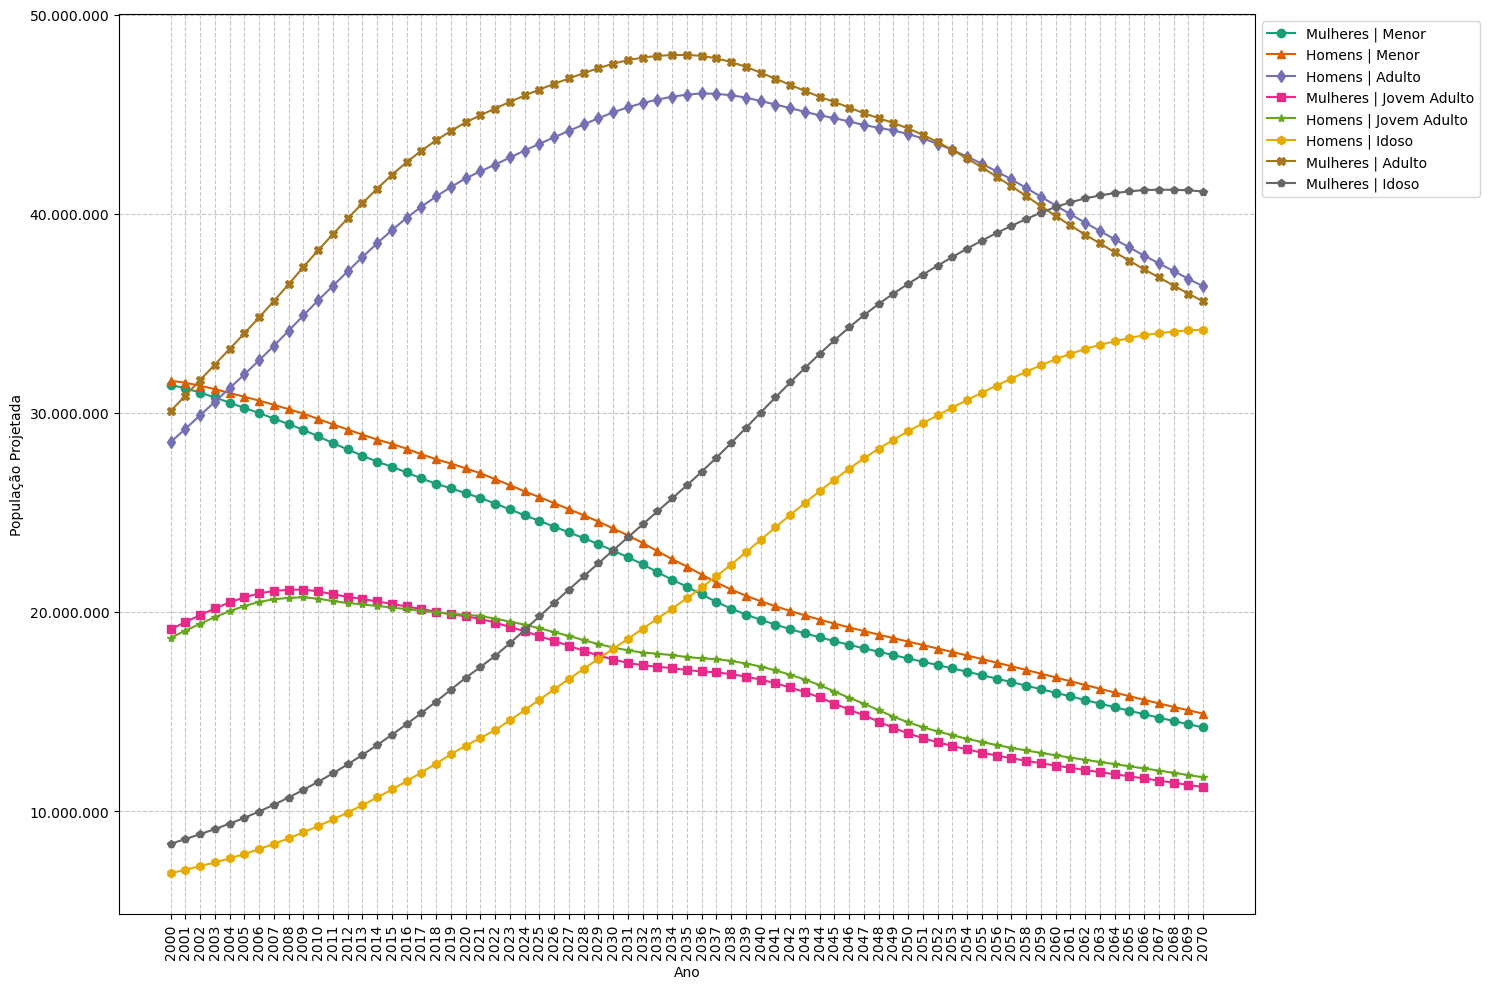

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))

cores = plt.get_cmap('Dark2').colors
marcadores = ['o', '^', 'd', 's', '*', 'h', 'X', 'p']

for ((sexo, grupo_etario), grupo), cor, marcador in zip(df_sexo_grupoetario_ano.group_by(['sexo', 'grupo_etario']), cores, marcadores):
    rotulo = f'{sexo} | {grupo_etario}'
    ax.plot(
        grupo.select('ano'),
        grupo.select('populacao_projetada'),
        color=cor,
        label=rotulo,
        marker=marcador
    ) 

ax.set_ylabel('População Projetada')
ax.set_xlabel('Ano')
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params('x', rotation=90)
ax.set_xticks(anos)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
)

plt.tight_layout()
plt.show()

# ANÁLISE POPULAÇÃO JOVEM ADULTA MASCULINA

In [18]:
df.head()

idade,sexo,ano,populacao_projetada
i8,cat,i16,f32
0,"""Ambos""",2000,3.423475e6
1,"""Ambos""",2000,3.450022e6
2,"""Ambos""",2000,3.461038e6
3,"""Ambos""",2000,3.469109e6
4,"""Ambos""",2000,3.477903e6


In [19]:
df_homensjovens = df.filter(
    pl.col('sexo') == 'Homens',
    pl.col('idade').is_in(range(18, 30))
).group_by('ano').agg(
    pl.col('populacao_projetada').sum()
).sort('ano', descending=False)

In [20]:
df_homensjovens.head()

ano,populacao_projetada
i16,f32
2000,1.8702208e7
2001,1.9061852e7
2002,1.9409636e7
2003,1.9739262e7
2004,2.0041468e7


In [21]:
max_homensjovens = df_homensjovens.filter(
    pl.col('populacao_projetada') == pl.col('populacao_projetada').max()
).row(0)[0] 

In [22]:
max_homensjovens

2009

In [23]:
min_homensjovens = df_homensjovens.filter(
    pl.col('populacao_projetada') == pl.col('populacao_projetada').min()
).row(0)[0] 

In [24]:
min_homensjovens

2070

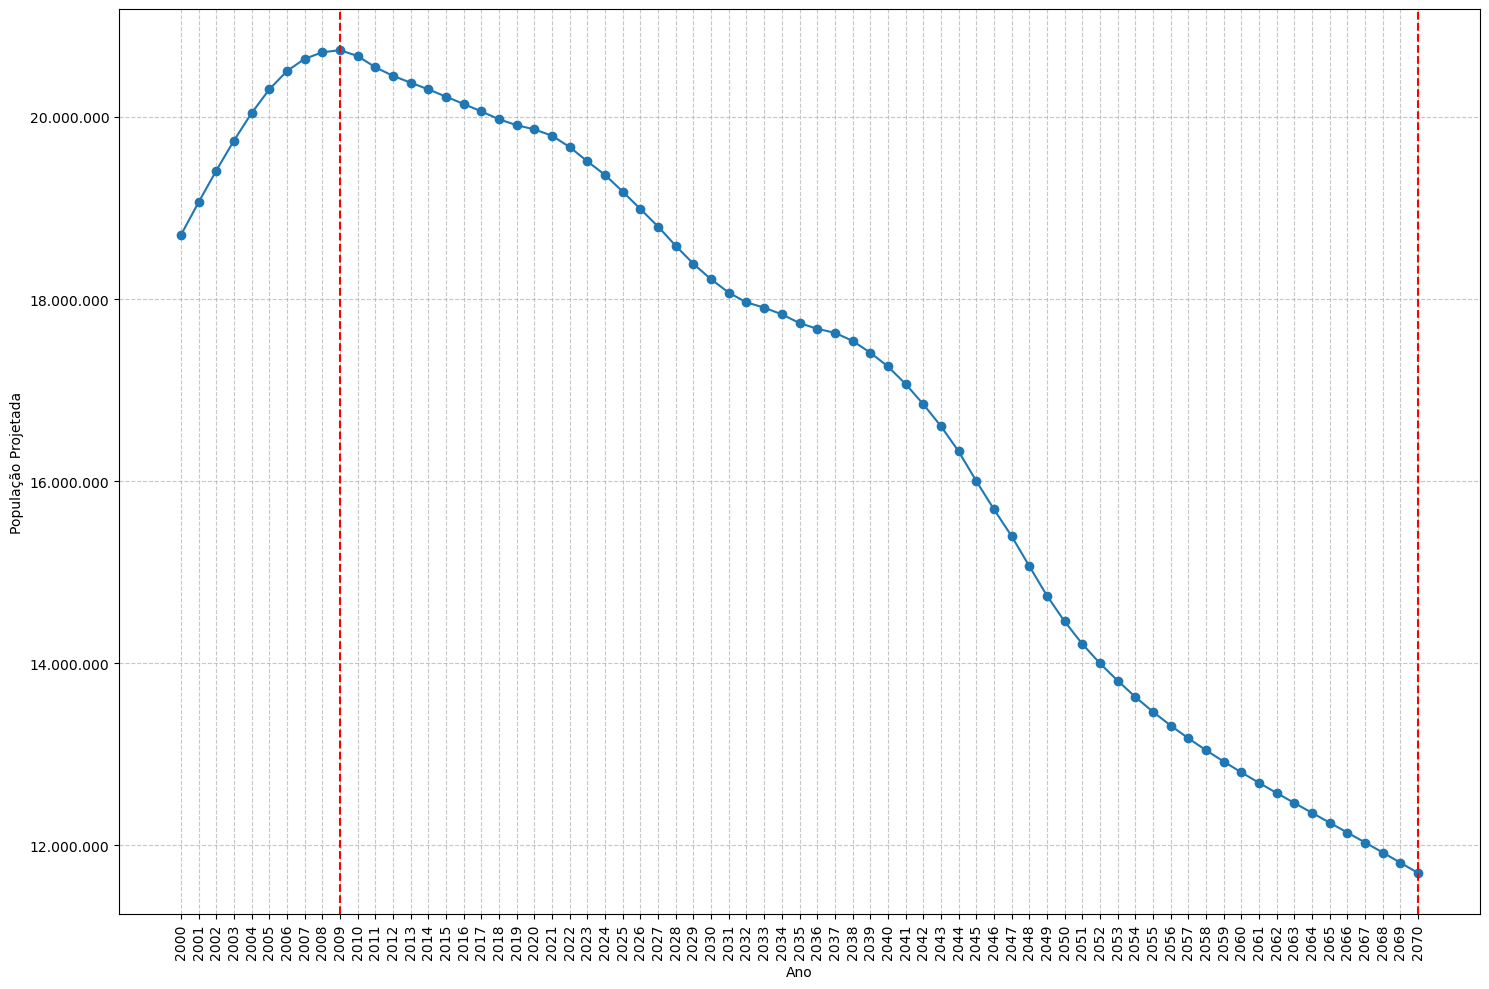

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(
    df_homensjovens.select('ano'),
    df_homensjovens.select('populacao_projetada'),
    marker='o'
)

ax.set_ylabel('População Projetada')
ax.set_xlabel('Ano')
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params('x', rotation=90)
ax.set_xticks(anos)
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
)
ax.axvline(max_homensjovens, color='red', linestyle='--')
ax.axvline(min_homensjovens, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# ANÁLISE POPULAÇÃO JOVEM ADULTA COM 18 ANOS

In [26]:
df.head()

idade,sexo,ano,populacao_projetada
i8,cat,i16,f32
0,"""Ambos""",2000,3.423475e6
1,"""Ambos""",2000,3.450022e6
2,"""Ambos""",2000,3.461038e6
3,"""Ambos""",2000,3.469109e6
4,"""Ambos""",2000,3.477903e6


In [27]:
df_homens_18anos = df.filter(
    pl.col('idade') == 18,
    pl.col('sexo') == 'Homens'
).group_by('ano').agg(
    pl.col('populacao_projetada').sum()
).sort('ano', descending=False)

In [28]:
df_homens_18anos.head()

ano,populacao_projetada
i16,f32
2000,1.765864e6
2001,1.775253e6
2002,1.783828e6
2003,1.784804e6
2004,1.77741e6


In [29]:
max_homens_18anos = df_homens_18anos.filter(
    pl.col('populacao_projetada') == pl.col('populacao_projetada').max()
).row(0)[0]

In [30]:
max_homens_18anos

2003

In [31]:
min_homens_18anos = df_homens_18anos.filter(
    pl.col('populacao_projetada') == pl.col('populacao_projetada').min()
).row(0)[0]

In [32]:
min_homens_18anos

2070

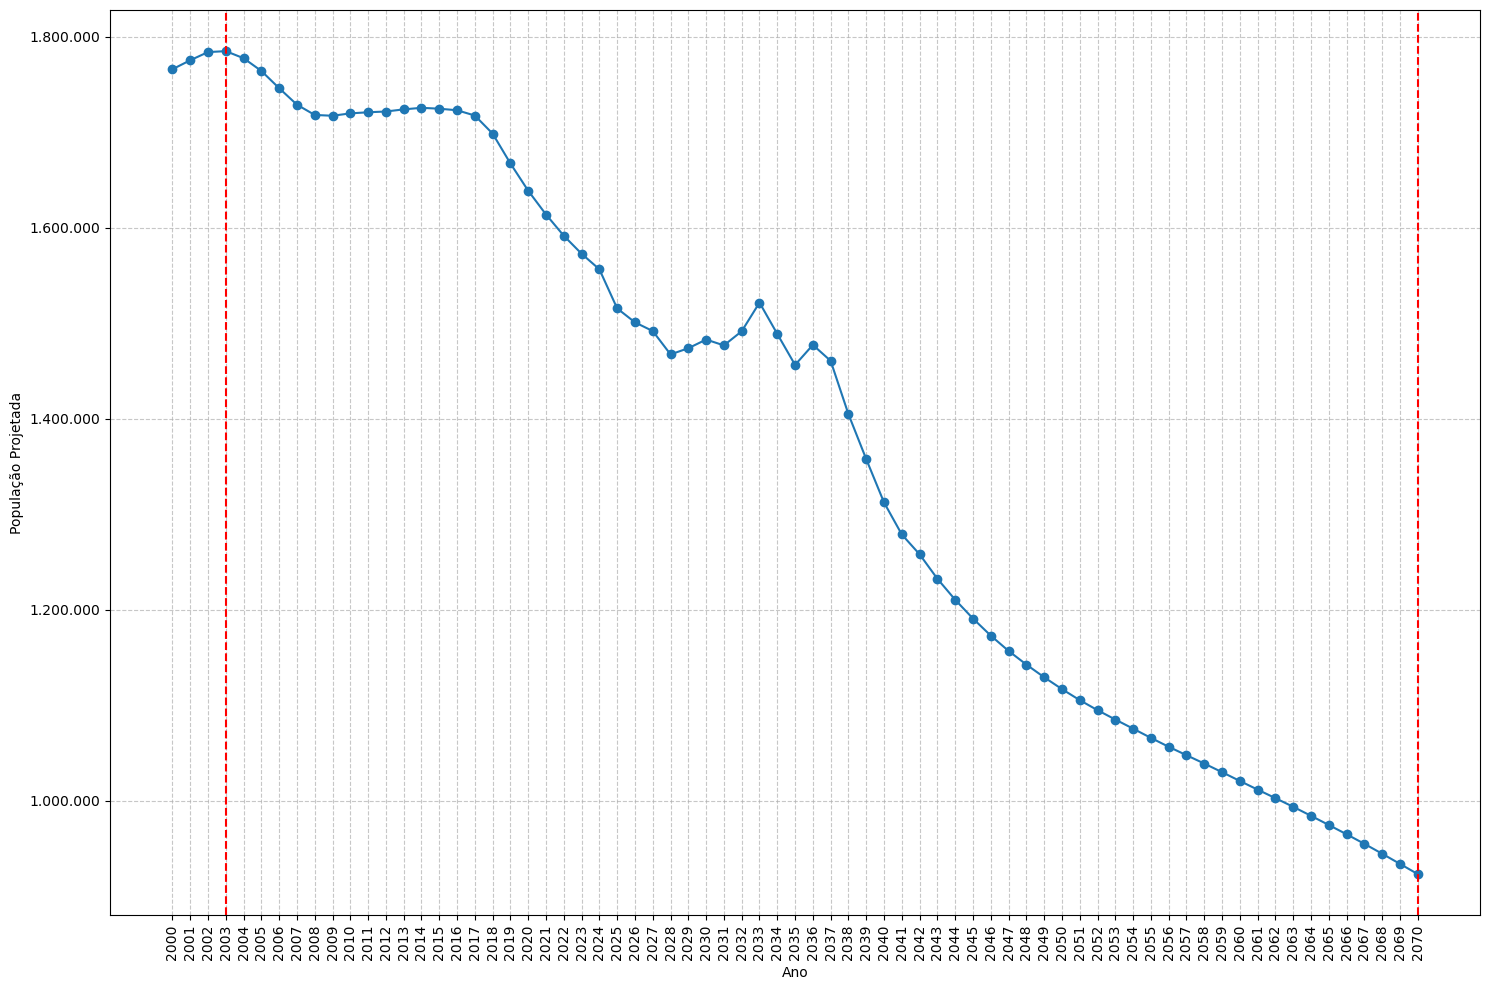

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(
    df_homens_18anos.select('ano'),
    df_homens_18anos.select('populacao_projetada'),
    marker='o'
)

ax.set_ylabel('População Projetada')
ax.set_xlabel('Ano')
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params('x', rotation=90)
ax.set_xticks(anos)
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
)
ax.axvline(max_homens_18anos, color='red', linestyle='--')
ax.axvline(min_homens_18anos, color='red', linestyle='--')

plt.tight_layout()
plt.show()